 ## correlation between temperature and the center of birds distribution in New York
 1. Region: New York
2. Bird specie: American Goldfinch("NABBP_2023_grp_39.csv")
3.Temperature: average monthly temperature from 1963-2010
4. Center: (Longitude, Latitude)
5. Conclusion: When temperatures rise in New York, American Goldfinches tend to shift northward.

In [2]:
import pandas as pd
from scipy.stats import mode
from geopy.geocoders import Nominatim
import requests
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from collections import OrderedDict
from scipy.optimize import minimize
import sklearn 
import math

In [6]:
columns_to_load = [ "EVENT_DAY", "EVENT_YEAR", "EVENT_MONTH",
                   'ISO_COUNTRY', 'ISO_SUBDIVISION','LAT_DD','LON_DD']
df = pd.read_csv("NABBP_2023_grp_39.csv", usecols=columns_to_load)
filtered_df = df[(df['ISO_COUNTRY'] == 'US')
                  &(1 <= df['EVENT_MONTH']) 
                  & (df['EVENT_MONTH'] <= 12) 
                 ].dropna()

In [7]:
filtered_df.isna().sum()

EVENT_DAY          0
EVENT_MONTH        0
EVENT_YEAR         0
ISO_COUNTRY        0
ISO_SUBDIVISION    0
LAT_DD             0
LON_DD             0
dtype: int64

In [8]:
grouped_by_states = filtered_df.groupby('ISO_SUBDIVISION')

In [9]:
count_by_state = {}
for state, group in grouped_by_states:
    count_by_state[state] = len(group)

In [10]:
sorted_by_count = OrderedDict(sorted(count_by_state.items(), key=lambda x: x[1], reverse=True))

In [11]:
sorted_by_count

OrderedDict([('US-MI', 146835),
             ('US-NY', 112149),
             ('US-PA', 108768),
             ('US-WI', 102387),
             ('US-OH', 102047),
             ('US-MD', 85710),
             ('US-TX', 77128),
             ('US-MN', 68650),
             ('US-IL', 53540),
             ('US-WV', 40484),
             ('US-IA', 39720),
             ('US-KS', 38168),
             ('US-VA', 33271),
             ('US-IN', 28676),
             ('US-MA', 28372),
             ('US-NJ', 26709),
             ('US-TN', 25448),
             ('US-CA', 24854),
             ('US-MO', 23566),
             ('US-NE', 22057),
             ('US-CT', 19040),
             ('US-SC', 18896),
             ('US-OK', 17275),
             ('US-AL', 14213),
             ('US-OR', 11852),
             ('US-ME', 10166),
             ('US-SD', 9726),
             ('US-NC', 8395),
             ('US-GA', 7497),
             ('US-VT', 6916),
             ('US-FL', 5056),
             ('US-LA', 4412),
         

In [12]:
grouped_by_year = filtered_df[filtered_df['ISO_SUBDIVISION'] == 'US-NY'].groupby('EVENT_YEAR')

In [13]:
years = []
for year, group in grouped_by_year:
    print(f"Year: {year}")
    print(len(group))
    years.append(year)

Year: 1960
208
Year: 1961
366
Year: 1962
851
Year: 1963
1640
Year: 1964
2079
Year: 1965
1040
Year: 1966
868
Year: 1967
807
Year: 1968
1203
Year: 1969
1190
Year: 1970
799
Year: 1971
1896
Year: 1972
3095
Year: 1973
2073
Year: 1974
1822
Year: 1975
1932
Year: 1976
1222
Year: 1977
2878
Year: 1978
1537
Year: 1979
2435
Year: 1980
3413
Year: 1981
1883
Year: 1982
2654
Year: 1983
3042
Year: 1984
2335
Year: 1985
1955
Year: 1986
1456
Year: 1987
1750
Year: 1988
1617
Year: 1989
3065
Year: 1990
2390
Year: 1991
1638
Year: 1992
2770
Year: 1993
4064
Year: 1994
1307
Year: 1995
2480
Year: 1996
1027
Year: 1997
1901
Year: 1998
1472
Year: 1999
2708
Year: 2000
1758
Year: 2001
2236
Year: 2002
2385
Year: 2003
3399
Year: 2004
3380
Year: 2005
3431
Year: 2006
2416
Year: 2007
4301
Year: 2008
1710
Year: 2009
2031
Year: 2010
2071
Year: 2011
698
Year: 2012
747
Year: 2013
564
Year: 2014
908
Year: 2015
618
Year: 2016
1752
Year: 2017
426
Year: 2018
719
Year: 2019
326
Year: 2020
756
Year: 2021
307
Year: 2022
323
Year: 202

In [14]:
temperatures = [
    27.6, 25.1, 38.6, 48.7, 56.8, 67.5, 73.0, 69.8, 61.5, 57.9, 48.6, 27.7,
    31.6, 29.9, 39.0, 46.4, 60.3, 67.3, 72.2, 68.8, 64.9, 53.1, 46.0, 34.1,
    26.4, 29.4, 36.6, 46.5, 61.3, 66.7, 71.2, 73.5, 67.4, 54.9, 45.1, 38.1,
    30.0, 29.3, 36.6, 43.4, 53.0, 67.9, 77.0, 74.9, 66.3, 54.9, 46.5, 33.8,
    33.8, 27.3, 33.5, 44.8, 51.1, 67.2, 73.7, 72.2, 65.4, 56.3, 41.0, 35.9,
    25.5, 27.9, 40.2, 51.7, 58.0, 67.1, 75.0, 73.3, 68.1, 58.8, 45.4, 32.4,
    30.5, 29.8, 37.0, 50.7, 59.8, 67.9, 71.6, 73.3, 64.9, 54.7, 45.0, 32.6,
    23.8, 31.5, 37.0, 49.3, 59.5, 66.9, 74.3, 73.6, 67.1, 57.5, 47.7, 32.6,
    26.2, 32.9, 38.1, 47.0, 57.2, 69.4, 73.5, 72.2, 69.0, 60.2, 43.4, 38.5,
    33.0, 29.9, 37.2, 46.0, 59.0, 65.3, 74.1, 72.8, 67.3, 51.2, 41.8, 35.0,
    30.4, 29.2, 42.0, 49.1, 55.5, 70.4, 75.2, 75.8, 67.9, 59.9, 48.0, 37.6,
    33.0, 29.5, 40.0, 52.2, 58.4, 68.6, 76.1, 75.1, 65.6, 52.9, 46.5, 37.4,
    35.2, 32.2, 36.8, 44.7, 61.8, 67.2, 74.4, 74.0, 64.4, 58.9, 50.5, 35.5,
    26.9, 36.3, 40.2, 51.1, 56.8, 70.3, 71.5, 73.1, 65.4, 53.5, 42.3, 29.9,
    23.7, 31.2, 41.8, 49.1, 60.4, 65.1, 72.6, 74.0, 67.8, 56.9, 50.0, 33.5,
    26.6, 24.1, 35.5, 46.9, 56.8, 66.4, 73.2, 75.0, 64.1, 55.4, 47.2, 36.2,
    30.5, 24.5, 43.0, 49.4, 61.6, 66.6, 73.7, 72.7, 64.8, 53.2, 47.3, 37.9,
    31.7, 28.0, 37.0, 48.1, 60.4, 67.3, 75.7, 75.9, 68.4, 55.4, 43.2, 31.3,
    22.1, 33.9, 38.0, 49.3, 58.6, 68.0, 73.9, 71.4, 62.8, 50.5, 44.1, 33.8,
    23.1, 32.8, 37.9, 46.3, 59.6, 63.9, 72.9, 69.2, 64.0, 52.9, 47.0, 38.7,
    31.4, 32.2, 40.5, 48.1, 55.7, 67.7, 74.3, 73.0, 67.3, 55.1, 46.5, 33.1,
    26.5, 36.5, 34.1, 47.9, 57.7, 71.0, 73.0, 74.8, 63.3, 57.7, 45.0, 40.2,
    26.2, 32.3, 41.7, 50.8, 60.9, 65.6, 73.6, 72.7, 66.6, 56.0, 46.6, 31.4,
    30.6, 29.1, 39.8, 50.6, 61.1, 66.8, 73.1, 70.6, 64.7, 54.2, 42.3, 35.5,
    30.0, 30.0, 41.3, 50.2, 58.8, 68.6, 74.9, 71.0, 65.2, 51.3, 44.9, 36.8,
    26.4, 31.2, 39.4, 48.1, 59.4, 68.2, 75.4, 75.5, 64.6, 50.5, 45.8, 32.7,
    33.8, 31.0, 38.8, 47.9, 59.5, 68.5, 71.8, 71.6, 65.2, 54.9, 43.2, 23.3,
    36.7, 35.0, 40.1, 49.2, 56.9, 69.1, 73.9, 73.9, 65.6, 59.6, 46.6, 40.0,
    31.7, 36.2, 42.2, 51.8, 64.4, 70.3, 75.4, 74.8, 65.1, 56.7, 45.9, 36.7,
    32.2, 33.8, 37.1, 46.5, 58.0, 67.1, 71.1, 70.4, 64.9, 52.1, 44.7, 36.0,
    33.6, 27.8, 36.6, 49.2, 61.4, 70.0, 76.7, 75.3, 65.7, 53.3, 45.0, 35.5,   # 1993
    23.4, 26.1, 37.5, 50.6, 58.6, 71.7, 78.4, 72.0, 65.4, 54.9, 48.9, 38.7,   # 1994
    35.6, 29.3, 41.3, 48.1, 58.5, 68.8, 77.0, 74.8, 66.1, 58.6, 41.6, 30.1,   # 1995
    28.4, 30.8, 36.1, 48.7, 57.4, 68.2, 71.2, 72.5, 66.2, 54.0, 40.7, 39.1,  # 1996
    30.2, 37.3, 38.7, 48.0, 56.1, 67.7, 73.1, 71.5, 65.1, 53.9, 42.2, 35.5,   # 1997
    36.7, 37.8, 41.0, 49.3, 60.9, 66.8, 73.7, 74.1, 67.4, 55.1, 45.6, 39.2,   # 1998
    31.0, 34.2, 39.7, 49.7, 59.5, 70.1, 77.3, 72.7, 67.2, 53.7, 47.9, 37.7,   # 1999
    28.6, 33.9, 43.2, 47.5, 59.6, 68.5, 70.4, 70.8, 64.4, 53.9, 43.6, 29.6,   # 2000
    29.5, 32.2, 36.5, 49.5, 60.3, 71.0, 71.6, 75.8, 66.0, 56.1, 49.2, 41.4,   # 2001
    36.4, 36.8, 40.6, 51.3, 57.2, 68.7, 76.0, 74.9, 67.8, 53.7, 42.9, 33.7,   # 2002
    25.9, 26.9, 38.0, 45.9, 56.2, 66.6, 73.9, 75.6, 67.0, 53.8, 47.5, 35.0,   # 2003
    21.9, 32.2, 40.0, 49.9, 60.5, 68.2, 73.2, 72.8, 68.8, 56.5, 47.6, 36.4,   # 2004
    29.6, 34.5, 37.1, 51.4, 55.5, 70.4, 74.9, 76.3, 69.8, 56.3, 46.5, 33.3,   # 2005
    36.6, 32.4, 39.6, 51.0, 58.7, 68.9, 76.4, 73.6, 64.8, 54.5, 49.2, 41.0,   # 2006
    34.8, 26.9, 37.6, 47.3, 61.1, 68.8, 73.1, 72.8, 67.5, 61.4, 44.6, 35.7,   # 2007
    34.6, 33.9, 40.4, 51.3, 58.4, 72.2, 76.7, 71.8, 67.3, 53.4, 44.0, 35.4,   # 2008
    25.2, 33.4, 38.0, 50.1, 58.8, 65.6, 71.2, 74.6, 64.9, 53.1, 49.0, 33.3,   # 2009
    29.7, 32.5, 45.0, 53.9, 62.1, 71.8, 78.0, 75.1, 69.3, 56.5, 45.7, 31.3,   # 2010
]

In [15]:
len(temperatures) == 12* (2010-1963+1)

True

In [16]:
grouped_by_month = filtered_df[(1963 <= filtered_df['EVENT_YEAR']) 
                                & (filtered_df['EVENT_YEAR'] <= 2010)].groupby(["EVENT_YEAR", "EVENT_MONTH"])

In [17]:
grouped_by_month.size()

EVENT_YEAR  EVENT_MONTH
1963        1               659
            2              1474
            3              3098
            4              3501
            5              1860
                           ... 
2010        8               829
            9              2652
            10             3885
            11             2966
            12              793
Length: 576, dtype: int64

In [18]:
### use mode as center
def calculate_mode(series):
    return mode(series, nan_policy='omit')[0]

def find_mode(grouped_by_month):
    mode_results = grouped_by_month[['LAT_DD', 'LON_DD']].apply(
        lambda group: pd.Series({
            'LAT_DD_mode': calculate_mode(group['LAT_DD']),
            'LON_DD_mode': calculate_mode(group['LON_DD'])
        })
    )
    return mode_results['LAT_DD_mode'].tolist(), mode_results['LON_DD_mode'].tolist()

lat_dd_modes, lon_dd_modes = find_mode(grouped_by_month)

In [19]:
def distance(coord1, coord2):  
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    return np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)

def weiszfeld_algorithm(grouped_by_month, max_iter=100, tol=1e-6):
    
    def objective_func(center,points):
        return sum(distance(center, p) for p in points)
    
    centers = []
    for group_keys,group_data in grouped_by_month:
        points = group_data[['LON_DD', 'LAT_DD']].to_numpy()
    
        initial_guess = np.mean(points, axis=0)
        result = minimize(objective_func, initial_guess, args=(points,),method='Nelder-Mead', options={'maxiter': max_iter, 'xatol': tol})
        centers.append(result.x)
    return centers

In [20]:
centers = weiszfeld_algorithm(grouped_by_month)
centers_lon = [i[0] for i in centers]
centers_lat = [i[1] for i in centers]

In [21]:
len(centers_lon) == len(centers_lat) == len(temperatures)

True

### graph

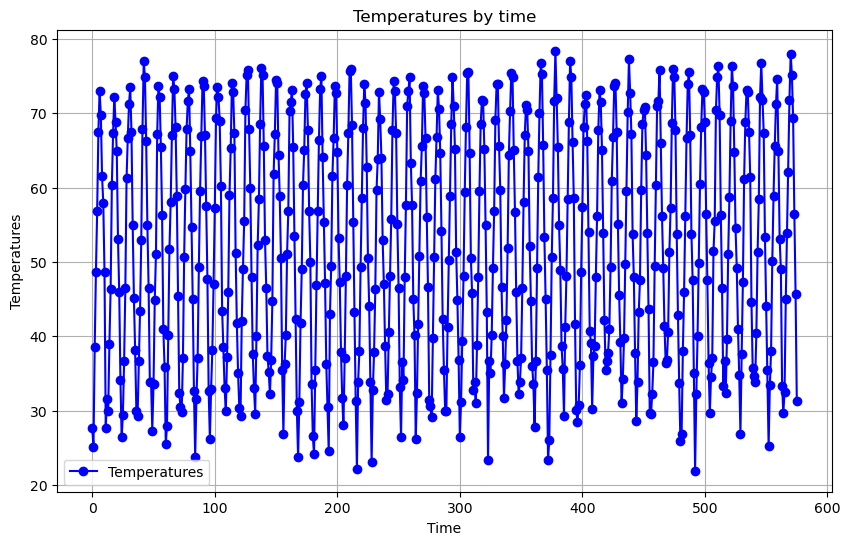

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(temperatures, label='Temperatures', color='blue', marker='o')

plt.xlabel('Time')
plt.ylabel('Temperatures')
plt.title('Temperatures by time')

plt.legend()

plt.grid(True)

plt.show()

In [23]:
combinations = list(zip(temperatures, centers_lat, centers_lon))
sorted_combinations = sorted(combinations, key=lambda x: x[0])
sorted_temperatures = [i[0] for i in sorted_combinations]
sorted_lat = [i[1] for i in sorted_combinations]
sorted_lon = [i[2] for i in sorted_combinations]

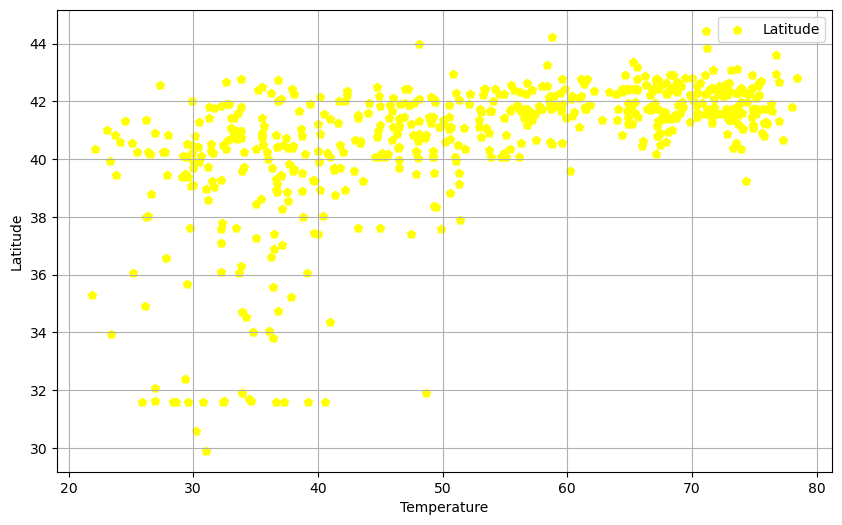

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter( sorted_temperatures, sorted_lat, label='Latitude', color='yellow', marker='p')
plt.xlabel('Temperature')
plt.ylabel('Latitude')


plt.legend()
plt.grid(True)
plt.show()

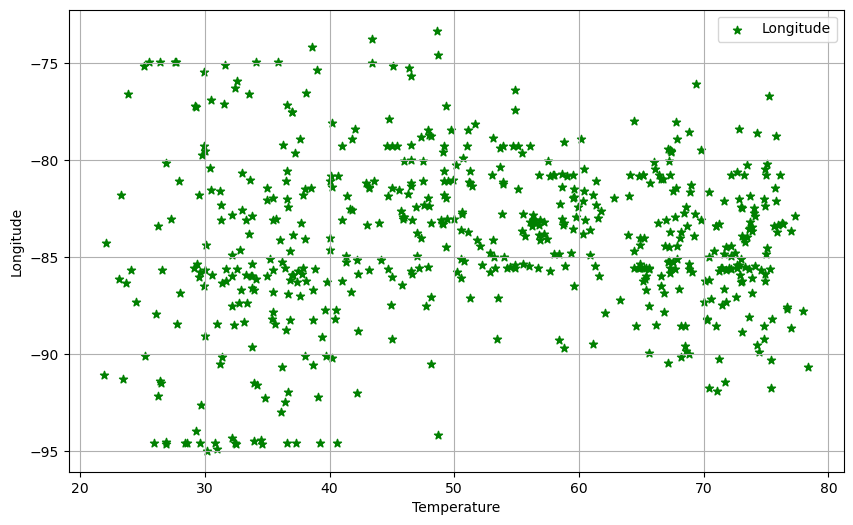

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(sorted_temperatures, sorted_lon, label='Longitude', color='green', marker='*')
plt.xlabel('Temperature')
plt.ylabel('Longitude')


plt.legend()
plt.grid(True)
plt.show()

### Mutual Information

In [26]:
mi_lon = mutual_info_regression(np.array(sorted_temperatures)[:,None], np.array(sorted_lon))

In [27]:
mi_lon

array([0.19180716])

In [28]:
mi_lat = mutual_info_regression(np.array(sorted_temperatures)[:, None], np.array(sorted_lat))

In [29]:
mi_lat

array([0.33689542])

Conclusion: Latitude and temperature have a strong positive correlation, while Longitude and temperature have only a very weak correlation.

### regression analysis of latitude and temperature 

#### use temperature as feature

In [30]:
def MSE(preds,labels):
    numer = 0
    for pred, label in zip(preds, labels):
        numer += (pred-label)**2
    return numer/len(labels)
        

In [31]:
features = list(zip([1]*len(sorted_temperatures),sorted_temperatures))
model = sklearn.linear_model.LinearRegression()
model.fit(features, sorted_lat)

LinearRegression()

In [32]:
preds = model.predict(features)

In [33]:
X = np.linspace(20, 80, 100).reshape(-1, 1)
feature = np.hstack([np.ones((X.shape[0], 1)), X])
y = model.predict(feature) 

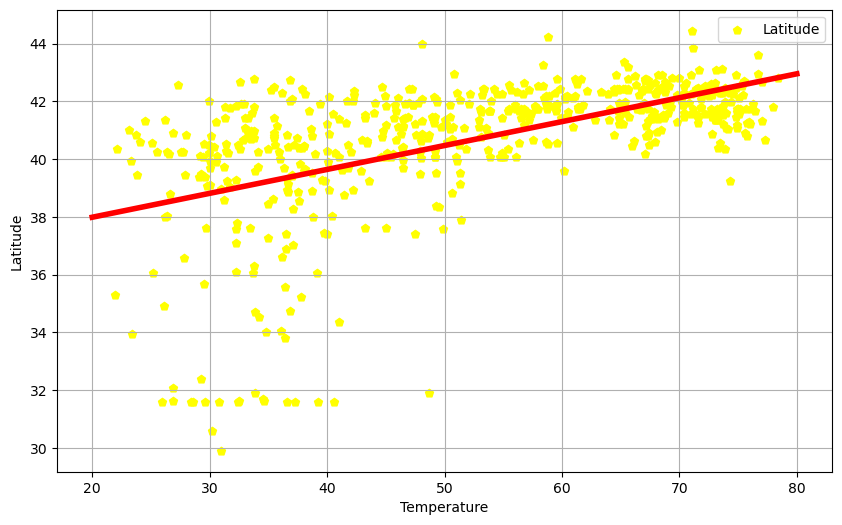

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, color='red',linewidth=4)
plt.scatter( sorted_temperatures, sorted_lat, label='Latitude', color='yellow', marker='p')
plt.xlabel('Temperature')
plt.ylabel('Latitude')


plt.legend()
plt.grid(True)
plt.show()

In [35]:
MSE(preds,sorted_lat)

4.029882974844622

#### use ln(temperature) as feature

In [36]:
ln_temperature = [math.log(i) for i in sorted_temperatures]

In [37]:
features = list(zip([1]*len(ln_temperature),ln_temperature))
model = sklearn.linear_model.LinearRegression()
model.fit(features, sorted_lat)

LinearRegression()

In [38]:
X = np.linspace(20, 80, 100).reshape(-1, 1)
feature = np.hstack([np.ones((X.shape[0], 1)), np.log(X)])
y = model.predict(feature) 

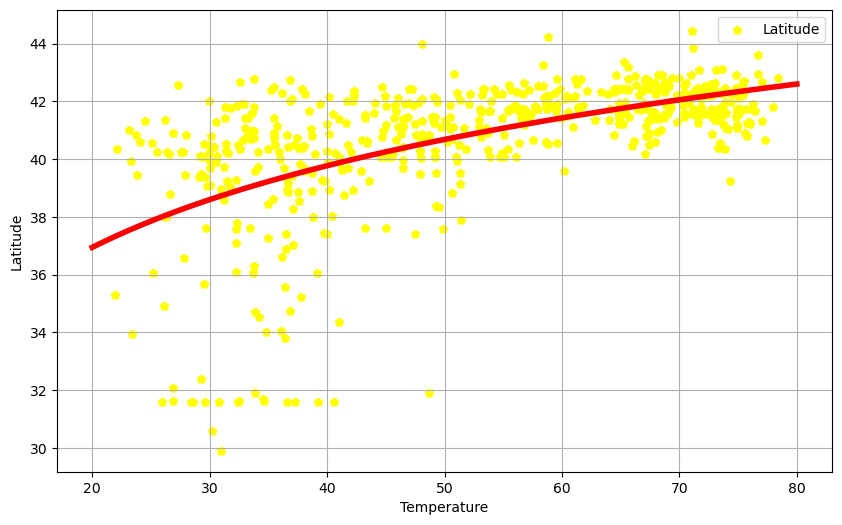

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, color='red',linewidth=4)
plt.scatter( sorted_temperatures, sorted_lat, label='Latitude', color='yellow', marker='p')
plt.xlabel('Temperature')
plt.ylabel('Latitude')


plt.legend()
plt.grid(True)
plt.show()

In [40]:
preds = model.predict(features)

In [41]:
MSE(preds,sorted_lat)

3.9575818925729505